# Notebook examples for Chapter 4
# Filters, Kernels, and Fields
Chapter 4 is intended  to
consolidate and extend material presented in the preceding three Chapters and to help  lay  the foundation for the rest of the book. In Sections 4.1 and 4.2, building on the discrete Fourier transform introduced in Chapter 3, the concept of discrete convolution  is introduced and filtering, both in the spatial and in the frequency domain, is discussed. Frequent reference to filtering will be made in Chapter 5 when  enhancement and geometric and radiometric correction of visual/infrared and SAR imagery are treated and in the discussion of convolutional neural networks in Chapter 6. In Section 4.3 it is shown that the discrete wavelet transform of Chapter 3 is equivalent to a
recursive application of low- and high-pass filters (a filter bank) and a pyramid algorithm for multi-scale image representation is described and programmed in Python. Wavelet pyramid representations are applied in Chapter 5 for
panchromatic sharpening and in Chapter 8 for contextual
clustering. Section 4.4 introduces  so-called {\it kernelization}, in which the dual representations of linear problems described in Chapters 2 and 3
can be modified to treat non-linear data. Kernel methods are illustrated with a non-linear version of the principal components transformation and they will be met again in Chapter 6 when  support vector machines for supervised classification are discussed, in Chapter 7 in connection with anomaly detection, and in Chapter 8 in the form of a kernel K-means clustering algorithm. Finally, Section 4.5 describes Gibbs--Markov random fields which are invoked in Chapter 8 in order to include spatial context in unsupervised  classification.

## 4.1 The Convolution Theorem

/home/mort/venvcrc5/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mort/venvcrc5/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


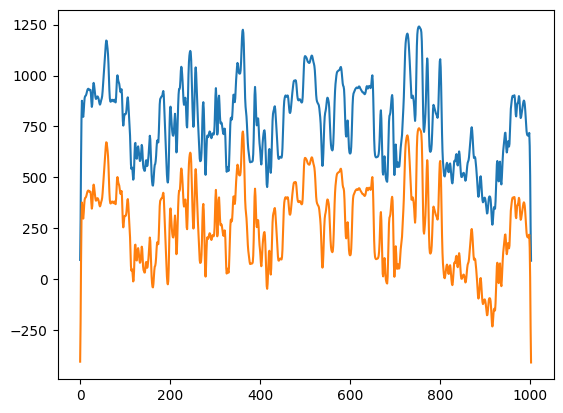

In [1]:
%matplotlib inline
import numpy as np
from numpy import fft
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly
import matplotlib.pyplot as plt

# get an image band
gdal.AllRegister()
infile = 'imagery/AST_20070501.tif'                 
inDataset = gdal.Open(infile,GA_ReadOnly)     
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize   

# pick out the middle row of pixels
band = inDataset.GetRasterBand(3)  
G = band.ReadAsArray(0, rows/2, cols,1).flatten()

# define a FIR kernel of length m = 5
h = np.array([1 ,2 ,3 ,2 ,1])

# convolve in the spatial domain
Gs = np.convolve(h,G)

# pad the arrays to c + m - 1
G = np.concatenate((G,[0, 0, 0, 0]))
hp = G*0
hp[0:5] = h

# convolve in the frequency domain
Gf = fft.ifft(fft.fft (G)* fft.fft(hp))-500

x = np.array(range(1004))
plt.plot(x,Gs,x,Gf)

 #plt.savefig('/home/mort/LaTeX/new projects/CRC5/Chapter4/fig4_1.eps')

(-8.0, 12.0)

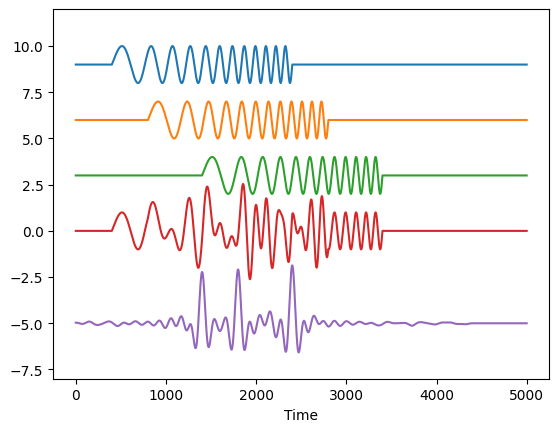

In [2]:
def chirp(t,t0):
    result = 0.0*t
    idx = np.array(range(2000))+t0 
    tt = t[idx] - t0
    result[idx] = np.sin(2*np.pi*2e-3*(tt+1e-3*tt**2))
    return result
 
t = np.array(range(5000))
plt.plot(t,chirp(t,400)+9)
plt.plot(t,chirp(t,800)+6)
plt.plot(t,chirp(t,1400)+3)
signal = chirp(t,400)+chirp(t,800)+chirp(t,1400)
kernel = chirp(t,0)[:2000]
kernel = kernel[::-1]
plt.plot(t,signal)
plt.plot(0.003*np.convolve(signal,kernel,\
                                 mode='same')-5)
plt.xlabel('Time')
plt.ylim((-8,12))

#plt.savefig('/home/mort/LaTeX/new projects/CRC5/Chapter5/fig4_2.eps')

## 4.2 Linear filters

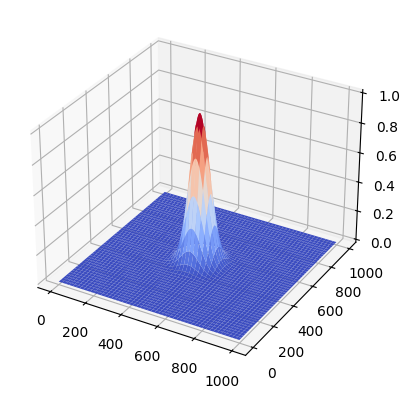

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from auxil import auxil1

# load the 3rd band from ASTER image
infile = 'imagery/AST_20070501.tif'
inDataset = gdal.Open(infile,GA_ReadOnly)     
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize 
band = inDataset.GetRasterBand(3)
G = band.ReadAsArray(0,0,cols,rows)

# Fourier transform
Gf = fft.fft2(G)
      
# create a Gaussian filter in frequency space
sigma = 50
Hf = auxil1.gaussfilter(sigma,1000,1000)

# low- and high-pass filtering in frequency domain
Gl = np.real(fft.ifft2(Gf*Hf))
Gh = np.real(fft.ifft2(Gf*(1.-Hf)))

# plot the filter
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x, y = np.meshgrid(range(rows),range(cols))
ax.plot_surface(x, y, np.roll(Hf,(rows//2,cols//2),(0,1)),cmap=cm.coolwarm)

#plt.savefig('/home/mort/LaTeX/new projects/CRC5/Chapter4/fig4_3.eps',bbox_inches='tight')

In [4]:
# save and plot the filtered bands
from osgeo import gdal
from osgeo.gdalconst import GDT_Float32
driver = gdal.GetDriverByName('Gtiff')   
outDataset = driver.Create('imagery/Gh.tif',
                cols,rows,2,GDT_Float32)        
outBand = outDataset.GetRasterBand(1)
outBand.WriteArray(Gl,0,0)
outBand = outDataset.GetRasterBand(2)
outBand.WriteArray(Gh,0,0)
outBand.FlushCache() 
outDataset = None    

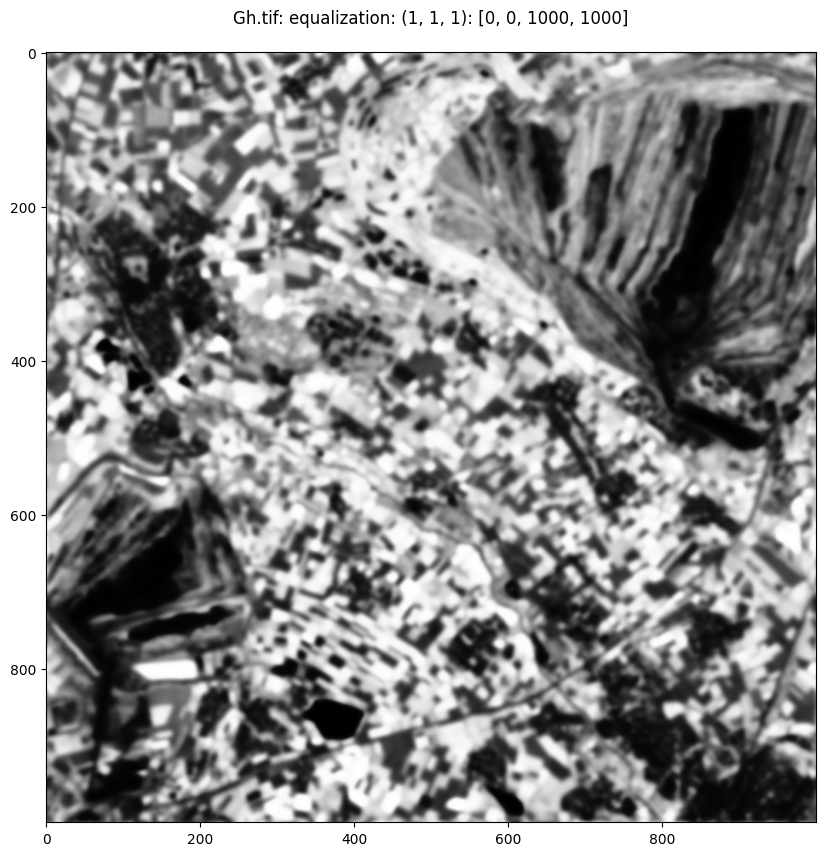

<Figure size 640x480 with 0 Axes>

In [5]:
%run scripts/dispms -f 'imagery/Gh.tif' -p [1,1,1] -e 4\
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter4/fig4_4.eps'

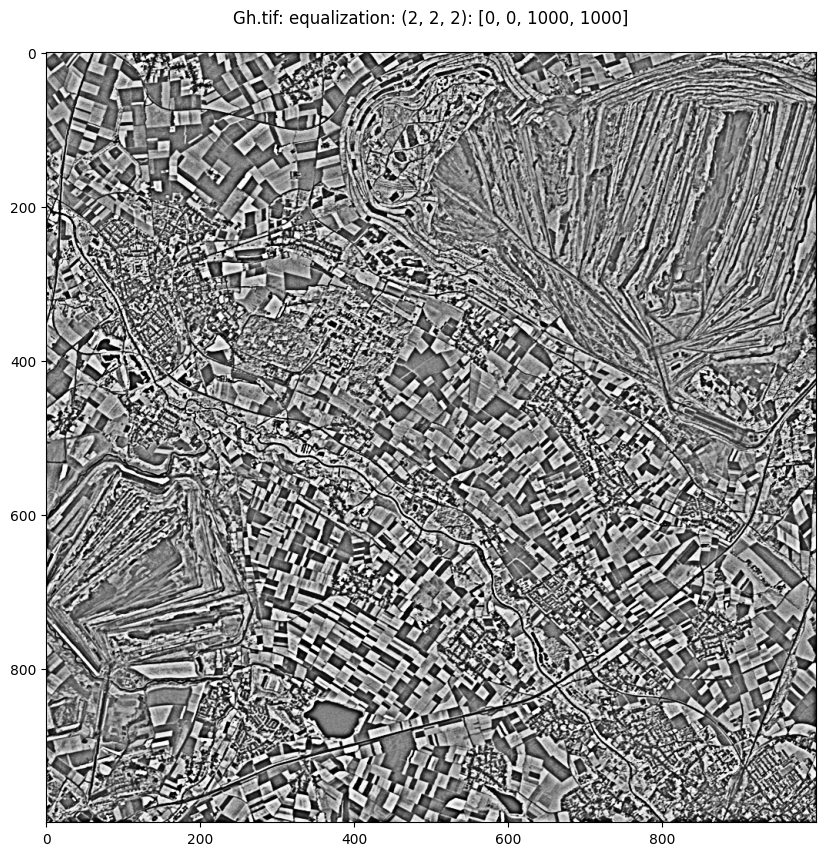

<Figure size 640x480 with 0 Axes>

In [6]:
%run scripts/dispms -f 'imagery/Gh.tif' -p [2,2,2] -e 4 \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter4/fig4_5.eps'

## 4.3 Wavelets and filter banks

### 4.3.1 One-dimensional arrays
### 4.3.2 Two dimensional arrays

In [ ]:
from auxil.auxil1 import DWTArray

# instantiate a DWTArray object
dwtarr = DWTArray(G, 1000, 1000)
data0 = np.copy(dwtarr.data)

# filter once
dwtarr.filter()
data1 = np.copy(dwtarr.data)
quad1 = np.abs(dwtarr.get_quadrant(1))

# filter again
dwtarr.filter()
data2 = dwtarr.data

# plot
f, ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].imshow(data0,cmap=cm.gray) 
ax[0,0].set_title('(a)')
ax[0,1].imshow(data1,cmap=cm.gray) 
ax[0,1].set_title('(b)')
ax[1,0].imshow(data2,cmap=cm.gray)  
ax[1,0].set_title('(c)')
ax[1,1].imshow(np.log(quad1-np.min(quad1)+1e-6),
                     cmap=cm.gray)
ax[1,1].set_title('(d)')

#plt.savefig('/home/mort/LaTeX/new projects/CRC5/Chapter4/fig4_11.eps',bbox_inches='tight')

## 4.4 Kernel methods

### 4.4.1 Valid kernels
### 4.4.2 Kernel PCA

In [ ]:
%run scripts/kpca -s 0 imagery/AST_20070501.tif

       kPCA
infile:  imagery/AST_20070501.tif
samples: 0
kernel:  Gaussian
running k-means on 100 cluster centers...


In [ ]:
%run scripts/dispms -f imagery/AST_20070501_kpca.tif -p [1,2,3] -e 4 \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter4/fig4_13.eps'

## 4.5 Gibs-Markov random fields